### **Stellar classification**

In [1]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=767b18534e7d243abfb6eda996720b8f8e461cbb26c804c75b9642f712e6c5c3
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
from google.colab import drive
import itertools
from datetime import datetime, timedelta
from sklearn.preprocessing import QuantileTransformer
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql.functions import col, udf, min, max, count, when, avg
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import ArrayType, DoubleType

 Dataset is made up of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey).

Each example is described by 17 feature columns and 1 class column which can be either a star, galaxy or quasar.
-	obj_ID: object Identifier, the ID that identifies the object
-	alpha: right ascension angle (at J2000 epoch)
-	delta: declination angle (at J2000 epoch)
-	u: ultraviolet filter value
-	g: green filter value
-	r: red filter value
- i: near infrared filter value
-	z: infrared filter value
-	run_ID: run number used to identify the specific scan
-	rereun_ID: rerun number used to specify how the image was processed
-	cam_col: camera column to identify the scanline within the run
-	field_ID: field number to identify each field
-	spec_obj_ID: unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
-	**Class**: object class (galaxy, star or quasar)
-	redshift: redshift value based on the increase in wavelength
-	plate: plate ID, identifies each plate in SDSS
-	MJD: modified julian date, used to indicate when a given piece of SDSS data was taken
-	fiber_ID: fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


# Data preparation

In [3]:
dataset_features = ['obj_ID','alpha','delta',
                    'u','g','r','i','z',
                    'run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID',
                    'redshift','plate','MJD','fiber_ID']

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
spark = SparkSession.builder.appName('Star classification').getOrCreate()
spark

In [6]:
path = "/content/drive/MyDrive/Big data/star_classification.csv"

data = spark.read.csv(path, header=True, inferSchema=True)
data.show()

+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+
|              obj_ID|           alpha|             delta|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class|    redshift|plate|  MJD|fiber_ID|
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+
|1.237660961327743...|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|   0.6347936| 5812|56354|     171|
|1.237664879951151...|144.826100550256|  31.2741848944939|24.77759|22.83188|22.58444|21.16812|21.61427|  4518|     301|      5|     119|1.176014203670733...|GALAXY|    0.779136|10445|58158|     427|
|1.23

In [7]:
data.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|59445|
|   QSO|18961|
|  STAR|21594|
+------+-----+



In [8]:
type(data)

pyspark.sql.dataframe.DataFrame

# Data analysis

In [9]:
data.dtypes

[('obj_ID', 'double'),
 ('alpha', 'double'),
 ('delta', 'double'),
 ('u', 'double'),
 ('g', 'double'),
 ('r', 'double'),
 ('i', 'double'),
 ('z', 'double'),
 ('run_ID', 'int'),
 ('rerun_ID', 'int'),
 ('cam_col', 'int'),
 ('field_ID', 'int'),
 ('spec_obj_ID', 'double'),
 ('class', 'string'),
 ('redshift', 'double'),
 ('plate', 'int'),
 ('MJD', 'int'),
 ('fiber_ID', 'int')]

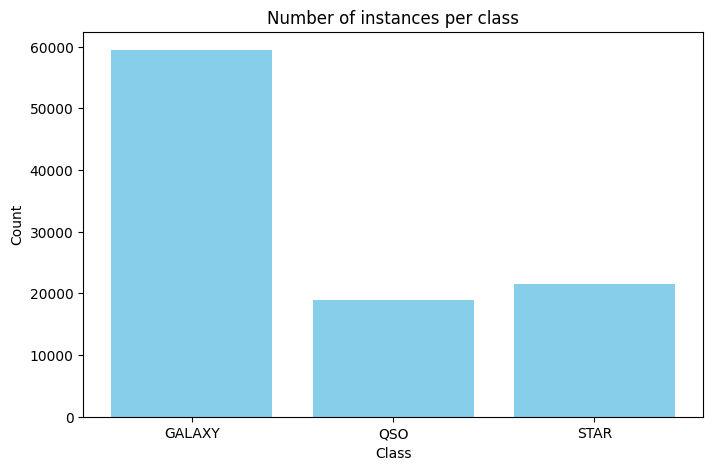

In [10]:
class_counts = data.groupBy("class").count()

class_counts_pd = class_counts.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(class_counts_pd['class'], class_counts_pd['count'], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of instances per class')
plt.show()


In [11]:
u_mean = data.groupBy('class').agg(avg('u').alias('ultraviolet_filter'))
g_mean = data.groupBy('class').agg(avg('g').alias('green_filter'))
r_mean = data.groupBy('class').agg(avg('r').alias('red_filter'))
redshift_mean = data.groupBy('class').agg(avg('redshift').alias('redshift_value'))
i_mean = data.groupBy('class').agg(avg('i').alias('near_infrared_filter'))
z_mean = data.groupBy('class').agg(avg('z').alias('infrared_filter'))

In [12]:
redshift_mean.show()
u_mean.show()
g_mean.show()
r_mean.show()
i_mean.show()
z_mean.show()

+------+--------------------+
| class|      redshift_value|
+------+--------------------+
|GALAXY|  0.4215961504447538|
|   QSO|  1.7196760892911382|
|  STAR|-1.14897203275575...|
+------+--------------------+

+------+------------------+
| class|ultraviolet_filter|
+------+------------------+
|GALAXY| 22.58737929026834|
|   QSO| 21.54761927324517|
|  STAR| 20.68980531397607|
+------+------------------+

+------+------------------+
| class|      green_filter|
+------+------------------+
|GALAXY|20.906101454453566|
|   QSO| 20.92619299245825|
|  STAR|19.153188379642533|
+------+------------------+

+------+------------------+
| class|        red_filter|
+------+------------------+
|GALAXY|19.587551746488224|
|   QSO| 20.62408902431311|
|  STAR|18.946969021024398|
+------+------------------+

+------+--------------------+
| class|near_infrared_filter|
+------+--------------------+
|GALAXY|  18.851989693329966|
|   QSO|  20.431172771478252|
|  STAR|  18.543735711910745|
+------+----------

In [13]:
# Collect all values into a List of Row objects, in order to print them with matplotlib
u_mean_values = [row['ultraviolet_filter'] for row in u_mean.select('ultraviolet_filter').collect()]
g_mean_values = [row['green_filter'] for row in g_mean.select('green_filter').collect()]
r_mean_values = [row['red_filter'] for row in r_mean.select('red_filter').collect()]
redshift_values = [row['redshift_value'] for row in redshift_mean.select('redshift_value').collect()]
i_values = [row['near_infrared_filter'] for row in i_mean.select('near_infrared_filter').collect()]
z_values = [row['infrared_filter'] for row in z_mean.select('infrared_filter').collect()]

In [14]:
classes = ['Galaxy', 'Qso', 'Star']

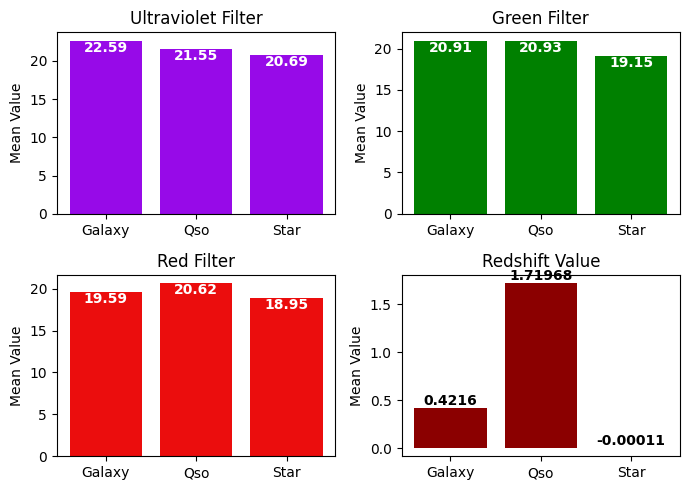

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

# Ultraviolet Filter
axs[0, 0].bar(classes, u_mean_values, color='#970AE8')
axs[0, 0].set_title('Ultraviolet Filter')
axs[0, 0].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[0, 0].text(classes[i], u_mean_values[i], round(u_mean_values[i], 2), fontsize=10, color='white',fontweight='bold', ha='center', va='top')

# Green Filter
axs[0, 1].bar(classes, g_mean_values, color='green')
axs[0, 1].set_title('Green Filter')
axs[0, 1].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[0, 1].text(classes[i], g_mean_values[i], round(g_mean_values[i], 2), fontsize=10, color='white', fontweight='bold',ha='center', va='top')

# Red Filter
axs[1, 0].bar(classes, r_mean_values, color='#EB0D0D')
axs[1, 0].set_title('Red Filter')
axs[1, 0].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[1, 0].text(classes[i], r_mean_values[i], round(r_mean_values[i], 2), fontsize=10, color='white',fontweight='bold', ha='center', va='top')

# Redshift Value
axs[1, 1].bar(classes, redshift_values, color='#8B0000')
axs[1, 1].set_title('Redshift Value')
axs[1, 1].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[1, 1].text(classes[i], redshift_values[i], round(redshift_values[i], 5), fontsize=10, color='black',fontweight='bold', ha='center', va='bottom')

plt.tight_layout()
plt.show()


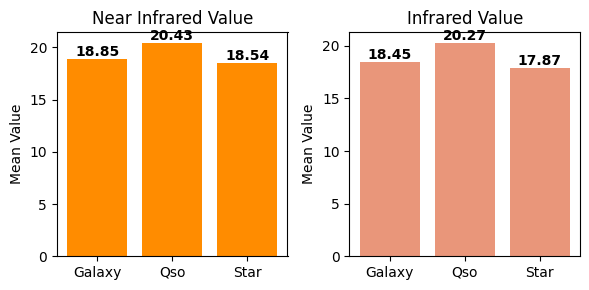

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Near Infrared Value
axs[0].bar(classes, i_values, color='#ff8c00')
axs[0].set_title('Near Infrared Value')
axs[0].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[0].text(classes[i], i_values[i], round(i_values[i], 2), fontsize=10, color='black', fontweight='bold', ha='center', va='bottom')

# Infrared Value
axs[1].bar(classes, z_values, color='#e9967a')
axs[1].set_title('Infrared Value')
axs[1].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[1].text(classes[i], z_values[i], round(z_values[i], 2), fontsize=10, color='black', fontweight='bold', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [17]:
# Count null values
null_counts = data.agg(*[(fn.count(fn.when(col(column).isNull(), column))).alias(column) for column in data.columns])
null_counts.show()

+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|obj_ID|alpha|delta|  u|  g|  r|  i|  z|run_ID|rerun_ID|cam_col|field_ID|spec_obj_ID|class|redshift|plate|MJD|fiber_ID|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|     0|    0|    0|  0|  0|  0|  0|  0|     0|       0|      0|       0|          0|    0|       0|    0|  0|       0|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+



Analysis of the data distribution

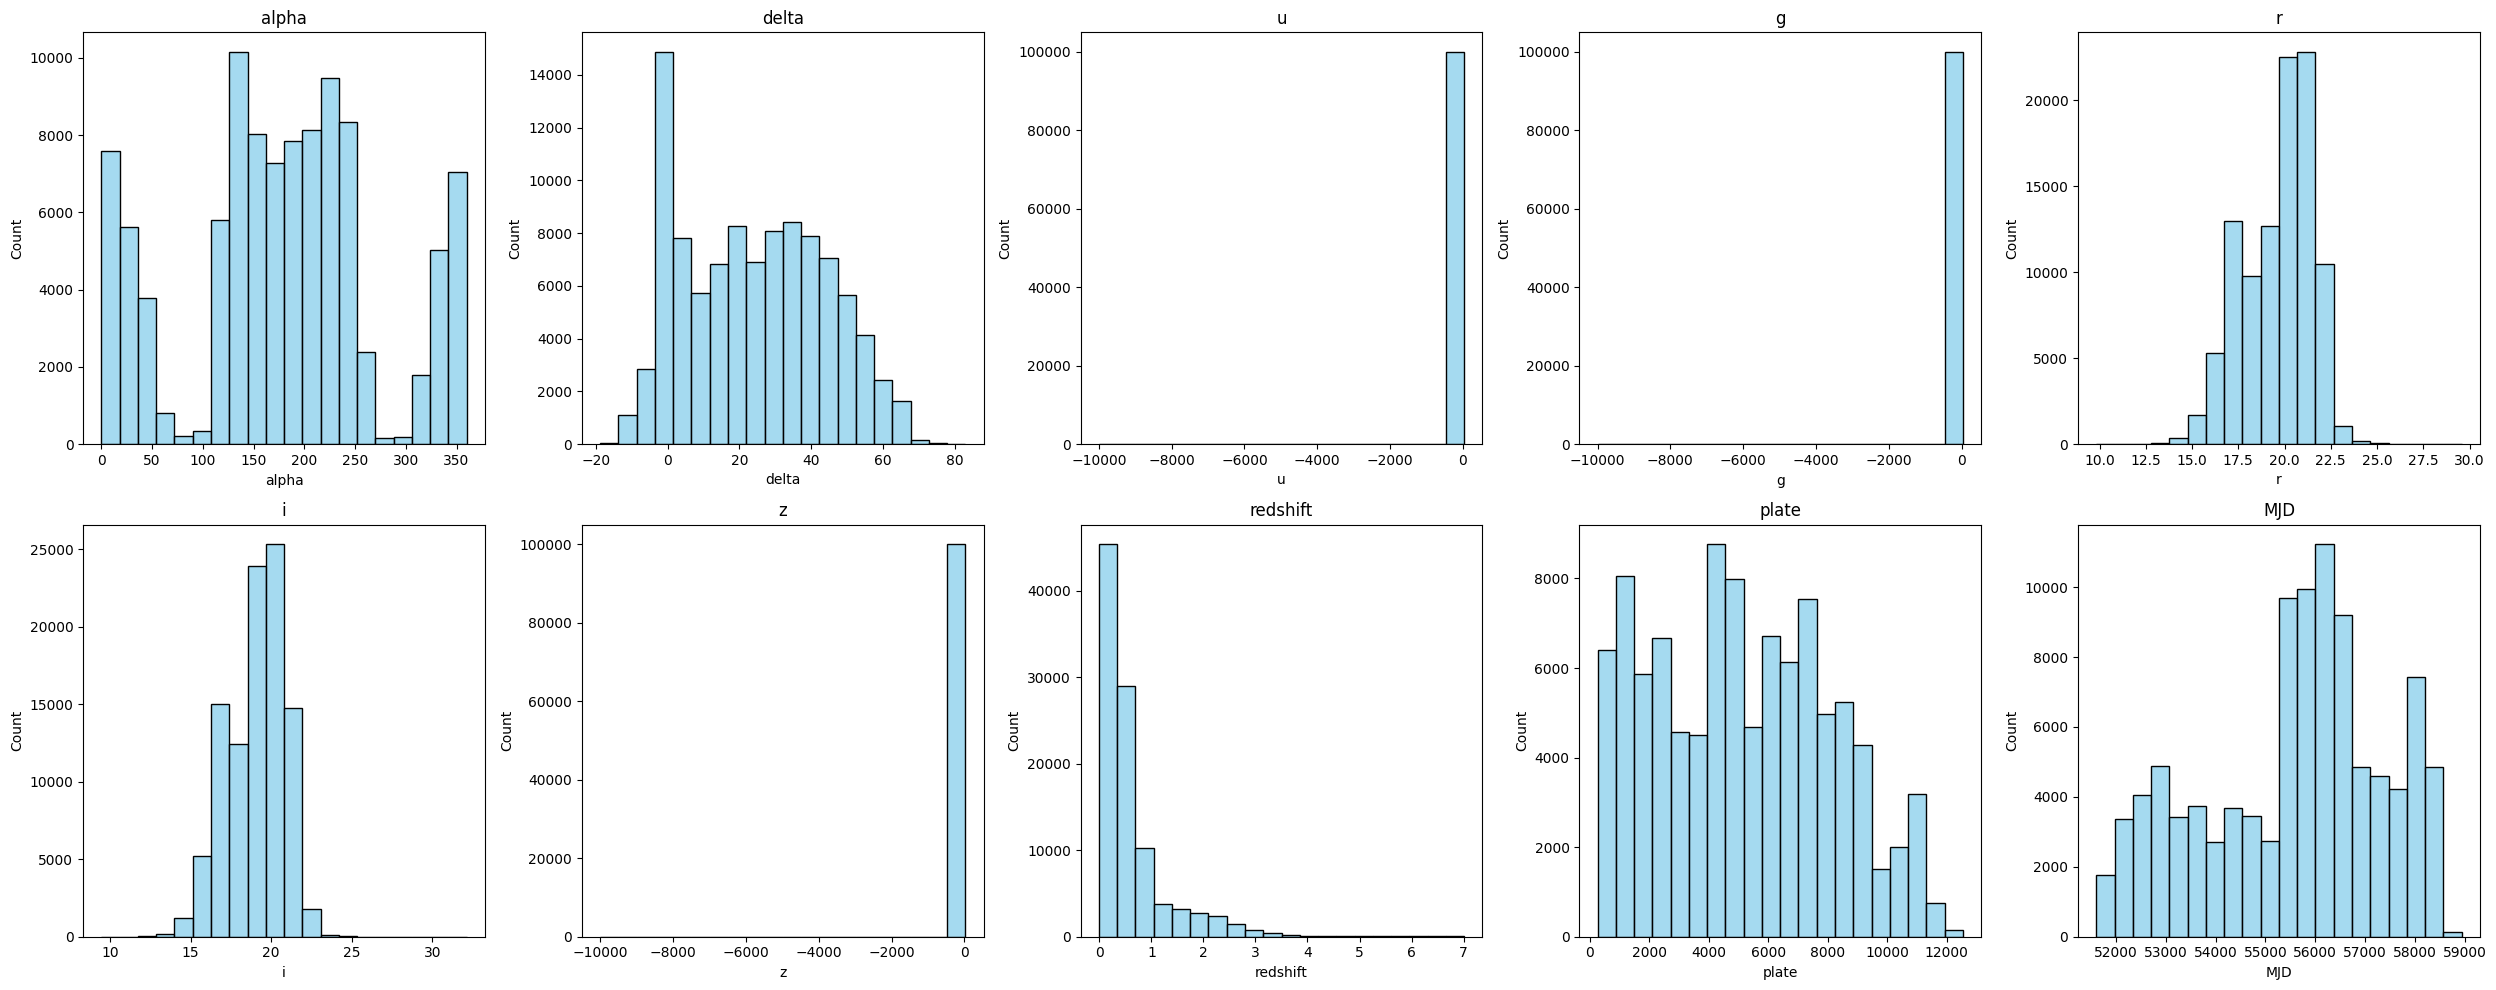

In [18]:
col_to_plot = ['alpha', 'delta','u','g','r','i','z','redshift','plate','MJD']
pandas_df = data.toPandas()

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
for i, col in enumerate(col_to_plot):
    ax = axes[i // 5, i % 5]
    sns.histplot(data=pandas_df[col], bins=20, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(col)
plt.tight_layout()
plt.show()


The **MJD** column of this dataset describes in what particulare date a stellar object has been taken by the SDSS17.

The MJD (modified julian date) gives the number of days since midnight on November 17, 1858.
This date corresponds to 2400000.5 days after day 0 of the Julian calendar. It's a unit of measurement used by astronomers.

This dataset has date in MJD, so i wrote a function to convert data in julian date.

In [19]:
def convert_to_julian_date(mjd):

  # data reference for this unit of measurement
  start_date = datetime(1858, 11, 17)

  date = start_date + timedelta(days=mjd)
  return date.strftime("%Y-%m-%d")

In [20]:
convert_to_julian_date(55864)

'2011-10-30'

In [21]:
convert_mjd_to_date_udf = udf(convert_to_julian_date, StringType())

# Apply the UDF to the DataFrame to convert all rows
converted_df = data.withColumn("date", convert_mjd_to_date_udf(data["mjd"]))
date_df = converted_df.select("date")

In [22]:
min_date = date_df.select(min("date")).first()[0]
max_date = date_df.select(max("date")).first()[0]

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2000-03-05
Maximum Date: 2020-03-24


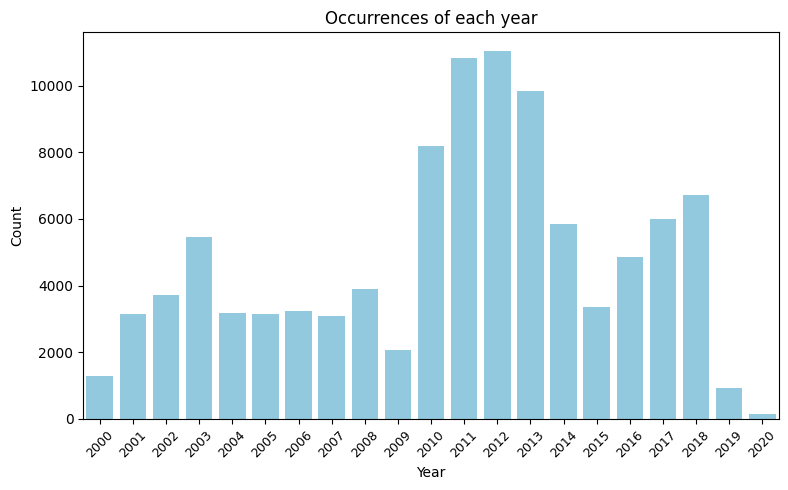

In [23]:
# Extract the year from the date column
date_df = date_df.withColumn('year', date_df['date'].substr(1, 4))

# Group the data by year and count the occurrences
date_counts_df = date_df.groupBy("year").agg(count("*").alias("count")).orderBy("year")

date_counts_pd = date_counts_df.toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x="year", y="count", data=date_counts_pd, color='skyblue')
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(fontsize=9, rotation=45)
plt.title("Occurrences of each year")
plt.tight_layout()
plt.show()

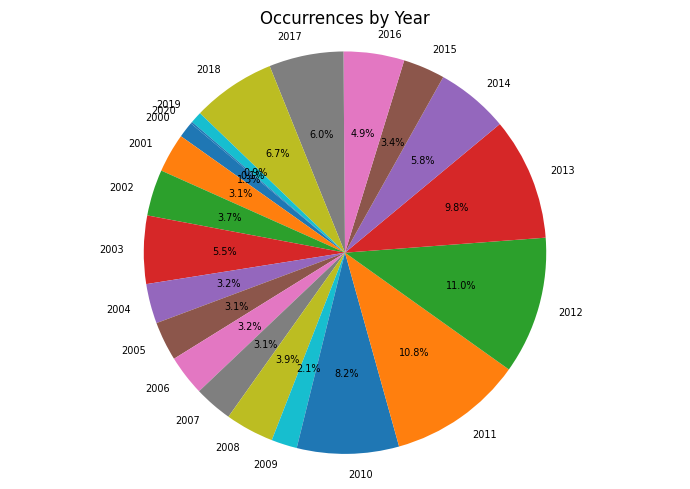

In [24]:
year_counts_df = date_df.groupBy(date_df['date'].substr(1, 4).alias("year")).count().orderBy("year")

year_counts_pd = year_counts_df.toPandas()

plt.figure(figsize=(7, 5))
plt.pie(year_counts_pd['count'], labels=year_counts_pd['year'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 7})
plt.title("Occurrences by Year")
plt.axis('equal')
plt.tight_layout()
plt.show()

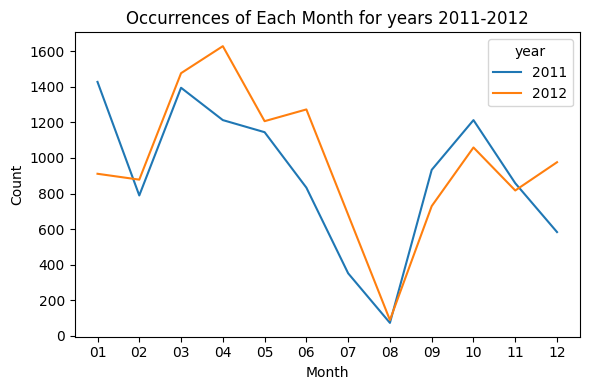

In [25]:
# Print for 2011 and 2012 (the years with most occurrences) the month in which most object have been discovered

filtered_df = date_df.filter((date_df['date'] >= '2011-01-01') & (date_df['date'] <= '2012-12-31'))
filtered_df = filtered_df.withColumn('year', filtered_df['date'].substr(1, 4))
filtered_df = filtered_df.withColumn('month', filtered_df['date'].substr(6, 2))

date_counts_df = filtered_df.groupBy("year", "month").agg(count("*").alias("count")).orderBy("year", "month")
date_counts_pd = date_counts_df.toPandas()

plt.figure(figsize=(6, 4))
sns.lineplot(x="month", y="count", hue="year", data=date_counts_pd, markers=False)  # Line plot without markers
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Occurrences of Each Month for years 2011-2012")
plt.tight_layout()
plt.show()

In [26]:
date_counts_df.createOrReplaceTempView("data_view")

query = """
SELECT year, month, count
FROM (
    SELECT year, month, count,
           ROW_NUMBER() OVER (PARTITION BY year ORDER BY count DESC) as rank
    FROM data_view
)
WHERE rank = 1
"""

result = spark.sql(query)
result.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2011|   01| 1428|
|2012|   04| 1629|
+----+-----+-----+



In [27]:
query = """
SELECT year, month, count
FROM (
    SELECT year, month, count,
           ROW_NUMBER() OVER (PARTITION BY year ORDER BY count ASC) as rank
    FROM data_view
)
WHERE rank = 1
"""

result = spark.sql(query)
result.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2011|   08|   72|
|2012|   08|   88|
+----+-----+-----+



In [28]:
query = """
SELECT year, SUM(count) AS total
FROM data_view
GROUP BY year
ORDER BY year;
"""

result = spark.sql(query)
result.show()

+----+-----+
|year|total|
+----+-----+
|2011|10813|
|2012|11044|
+----+-----+



# Features engineering



In [29]:
def hist_plot(dataset):
  plt.figure(figsize=(2, 2))
  plt.hist(dataset, bins=30, color='skyblue', edgecolor='black')
  plt.title('data distribution')
  plt.xlabel('value')
  plt.ylabel('frequency')
  plt.grid(True)
  plt.show()

Feature scaling

In [30]:
features_to_scale = ['u', 'z', 'i', 'r', 'g', 'redshift','alpha','delta']

In [34]:

assembler = VectorAssembler(inputCols=features_to_scale, outputCol="features")
assembled_df = assembler.transform(data)


scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

scaler_model = scaler.fit(assembled_df)
X_scaled = scaler_model.transform(assembled_df)


In [37]:
# Re-assembling the obtained Local vector of scaled features in single columns
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType
def extract_values(scaled_features):
    return scaled_features.toArray().tolist()

for col_name in features_to_scale:
  X_scaled=X_scaled.drop(col_name)
X_scaled=X_scaled.drop("features")

extract_values_udf = udf(extract_values, ArrayType(DoubleType()))

# Apply UDF to create new columns with only scaled features, 'values' is a temporary column
X_scaled = X_scaled.withColumn("values", extract_values_udf(col("scaled_features")))

for i, new_col in enumerate(features_to_scale):
    X_scaled = X_scaled.withColumn(new_col, col("values").getItem(i))

X_scaled = X_scaled.drop("scaled_features").drop("values")
X_scaled.show()

+--------------------+------+--------+-------+--------+--------------------+------+-----+-----+--------+------------------+------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+
|              obj_ID|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class|plate|  MJD|fiber_ID|                 u|                 z|                  i|                  r|                 g|            redshift|               alpha|              delta|
+--------------------+------+--------+-------+--------+--------------------+------+-----+-----+--------+------------------+------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+
|1.237660961327743...|  3606|     301|      2|      79|6.543777369295181...|GALAXY| 5812|56354|     171|0.9991125633968784| 0.998943994339012| 0.4276646162128979| 0.5353444264470659|0.9990701515445597|  0.091

Rerun_ID contains the same values for each example, so It was removed

In [38]:
dataset_features = ['obj_ID','alpha','delta',
                    'u','g','r','i','z',
                    'run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID',
                    'redshift','plate','MJD','fiber_ID', 'class']

In [39]:
X_scaled=X_scaled.drop('rerun_ID')
dataset_features.remove('rerun_ID')

In [40]:
X_scaled = X_scaled.withColumn('class',
                                     when(X_scaled['class'] == 'GALAXY', 0)
                                    .when(X_scaled['class'] == 'QSO', 1)
                                    .when(X_scaled['class'] == 'STAR', 2)
                                    .otherwise(X_scaled['class'].cast('int')))

Feature correlation

In [41]:
assembler = VectorAssembler(inputCols=dataset_features, outputCol="features")
assembled_df = assembler.transform(X_scaled)

In [42]:
# Compute correlation matrix
corr_matrix = Correlation.corr(assembled_df, "features", "spearman").collect()[0][0]
corr_df = pd.DataFrame(corr_matrix.toArray(), columns=dataset_features, index=dataset_features)

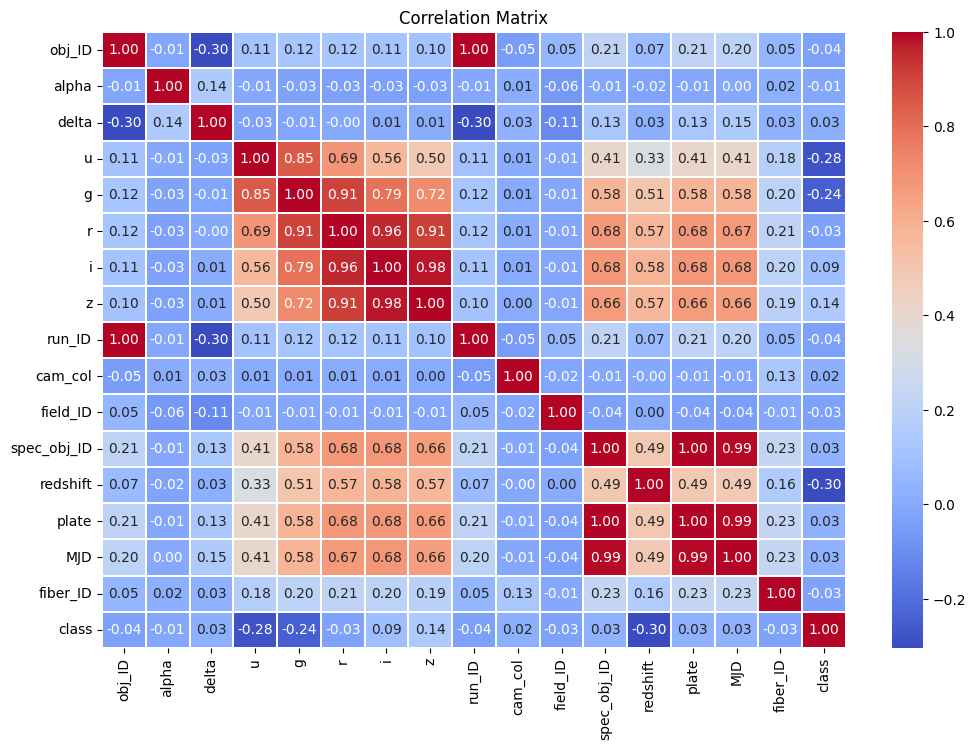

In [43]:
mask = corr_df.isnull()
corr_df.index, corr_df.columns = dataset_features, dataset_features

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.1)
plt.gca().patch.set_facecolor('lightgrey')

plt.title("Correlation Matrix")
plt.show()

In [44]:
correlations_with_class = corr_df['class']

sorted_correlations = correlations_with_class.abs().sort_values(ascending=False)
sorted_correlations = sorted_correlations.drop(labels='class')

selected_features_corr_target = sorted_correlations[sorted_correlations > 0.03]

In [45]:
sorted_correlations

,class
redshift,0.304301
u,0.280591
g,0.244818
z,0.142171
i,0.087809
run_ID,0.039164
obj_ID,0.039022
r,0.034202
MJD,0.031478
field_ID,0.031277


In [46]:
threshold_features = list(selected_features_corr_target.index)
threshold_features.append('class')

selected_df = X_scaled.select(threshold_features)


selected_df = selected_df.withColumn('class',
                                     when(selected_df['class'] == 'GALAXY', 0)
                                    .when(selected_df['class'] == 'QSO', 1)
                                    .when(selected_df['class'] == 'STAR', 2)
                                    .otherwise(selected_df['class'].cast('int')))

selected_df = selected_df.select(threshold_features)
selected_df.show()

+--------------------+------------------+------------------+------------------+-------------------+------+--------------------+-------------------+-----+--------+--------------------+-----+-----+
|            redshift|                 u|                 g|                 z|                  i|run_ID|              obj_ID|                  r|  MJD|field_ID|         spec_obj_ID|plate|class|
+--------------------+------------------+------------------+------------------+-------------------+------+--------------------+-------------------+-----+--------+--------------------+-----+-----+
|  0.0918308591531262|0.9991125633968784|0.9990701515445597| 0.998943994339012| 0.4276646162128979|  3606|1.237660961327743...| 0.5353444264470659|56354|      79|6.543777369295181...| 5812|    0|
| 0.11238889451990965|0.9992021556602121|0.9991256397382576|0.9992252520245103|  0.515986257147554|  4518|1.237664879951151...| 0.6462028203844193|58158|     119|1.176014203670733...|10445|    0|
| 0.0931697868325855

In [47]:
selected_df

DataFrame[redshift: double, u: double, g: double, z: double, i: double, run_ID: int, obj_ID: double, r: double, MJD: int, field_ID: int, spec_obj_ID: double, plate: int, class: int]

# Data balancing

In [48]:
# DATASET with feature selection
ratio = 1
galaxy_count = selected_df.filter(fn.col('class') == 0).count()
qso_count = selected_df.filter(fn.col('class') == 1).count()
star_count = selected_df.filter(fn.col('class') == 2).count()

# Oversample of class 1 (QSO)
balance_ratio_qso = galaxy_count / qso_count
oversampled_qso = selected_df.filter(fn.col('class') == 1)\
                            .sample(withReplacement=True, fraction=(balance_ratio_qso / ratio), seed=88)

oversampled_df = selected_df.filter(fn.col('class') == 0).union(oversampled_qso)

# Oversample of class 2 (STAR)
balance_ratio_star = galaxy_count / star_count
oversampled_star = selected_df.filter(fn.col('class') == 2)\
                             .sample(withReplacement=True, fraction=(balance_ratio_star / ratio), seed=88)

oversampled_df = oversampled_df.union(oversampled_star)
oversampled_df.groupBy('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    0|59445|
|    1|59568|
|    2|59379|
+-----+-----+




# Data transformation for training phase


In [49]:
feature_columns = oversampled_df.columns[:-1]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
transformed_df = assembler.transform(oversampled_df)

transformed_df = transformed_df.withColumnRenamed("target_variable_column", "class")
transformed_df = transformed_df.select("features", "class")
transformed_df.show()

+--------------------+-----+
|            features|class|
+--------------------+-----+
|[0.09183085915312...|    0|
|[0.11238889451990...|    0|
|[0.09316978683258...|    0|
|[0.13420984508835...|    0|
|[0.01795890811225...|    0|
|[0.06935831202121...|    0|
|[0.09542260183645...|    0|
|[0.06687822868153...|    0|
|[0.08565180098747...|    0|
|[0.02309632329942...|    0|
|[0.11794686365955...|    0|
|[0.07048629332467...|    0|
|[0.01731303705301...|    0|
|[0.05479492231070...|    0|
|[0.09574983861551...|    0|
|[0.00598924730337...|    0|
|[0.03716264809046...|    0|
|[0.06711784530631...|    0|
|[0.08845094588375...|    0|
|[0.01439286753075...|    0|
+--------------------+-----+
only showing top 20 rows



In [50]:
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=0)

# Training and test

In [51]:
def eval_results(predictions):
  # Accuracy
  evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)

  # Precision
  evaluator.setMetricName("weightedPrecision")
  precision = evaluator.evaluate(predictions)

  # Recall
  evaluator.setMetricName("weightedRecall")
  recall = evaluator.evaluate(predictions)

  #F1
  f1_score = 2 * (precision * recall) / (precision + recall)
  return accuracy, precision, recall, f1_score


# **Evaluation**

# Decision tree classifier

In [54]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Implemented using DecisionTreeClassifier from the pyspark library

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")
train_data = train_data.withColumnRenamed("label", "class")


param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()


evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)

best_model = cv_model.bestModel

predictions = best_model.transform(test_data)

acc, prec, rec, f1 = eval_results(predictions)
print("Evaluation results:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Evaluation results:
Accuracy:  0.979
Precision: 0.979
Recall:    0.979
F1 Score:  0.979


In [ ]:
best_model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_415653c254e8, depth=15, numNodes=3367, numClasses=3, numFeatures=11

In [ ]:
best_params = {param[0].name: param[1] for param in best_model.extractParamMap().items()}

best_params

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featuresCol': 'features',
 'impurity': 'gini',
 'labelCol': 'class',
 'leafCol': '',
 'maxBins': 64,
 'maxDepth': 15,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'seed': -5992620546964108614}

# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features",labelCol="class", numTrees=10, maxDepth=5, seed=42)

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

cross_validator = CrossValidator(estimator=rf,
      estimatorParamMaps=paramGrid,
      evaluator=MulticlassClassificationEvaluator(labelCol="class", metricName="accuracy"),
      numFolds=5, seed=42)

In [ ]:
cv_model = cross_validator.fit(train_data)
best_rf_model = cv_model.bestModel

In [ ]:
print("numTrees:", best_rf_model.getOrDefault("numTrees"))
print("maxDepth:", best_rf_model.getOrDefault("maxDepth"))

numTrees: 30
maxDepth: 15


In [ ]:
predictions = best_rf_model.transform(test_data)

acc, prec, rec, f1 = eval_results(predictions)
print("Evaluation results:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Evaluation results:
Accuracy:  0.981
Precision: 0.981
Recall:    0.981
F1 Score:  0.981


In [ ]:
best_params = {param[0].name: param[1] for param in best_rf_model.extractParamMap().items()}
best_params

{'bootstrap': True,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featureSubsetStrategy': 'auto',
 'featuresCol': 'features',
 'impurity': 'gini',
 'labelCol': 'class',
 'leafCol': '',
 'maxBins': 32,
 'maxDepth': 15,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'numTrees': 30,
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'seed': 42,
 'subsamplingRate': 1.0}

In [ ]:
importances = best_rf_model.featureImportances

feature_importance_list = [float(x) for x in importances.toArray()]
for i, importance in enumerate(feature_importance_list):
    print(f"Feature {i}: {importance:.4f}")

Feature 0: 0.6060
Feature 1: 0.0576
Feature 2: 0.0665
Feature 3: 0.1048
Feature 4: 0.0488
Feature 5: 0.0061
Feature 6: 0.0063
Feature 7: 0.0301
Feature 8: 0.0154
Feature 9: 0.0070
Feature 10: 0.0221
Feature 11: 0.0292


In [ ]:
input_cols = assembler.getInputCols()

feature_importance_data = list(zip(input_cols, feature_importance_list))

feature_importance_df = spark.createDataFrame(feature_importance_data, ["Feature", "Importance"])
feature_importance_df.orderBy(feature_importance_df.Importance.desc()).show(truncate=False)

+-----------+--------------------+
|Feature    |Importance          |
+-----------+--------------------+
|redshift   |0.606012333681438   |
|z          |0.10478071587063131 |
|g          |0.06653036652995584 |
|u          |0.05755940051567711 |
|i          |0.04881879690836257 |
|r          |0.03010443842597543 |
|plate      |0.029230840747166267|
|spec_obj_ID|0.02211494657057388 |
|MJD        |0.015447171292705387|
|field_ID   |0.007022849891721549|
|obj_ID     |0.006324562811671466|
|run_ID     |0.006053576754121074|
+-----------+--------------------+



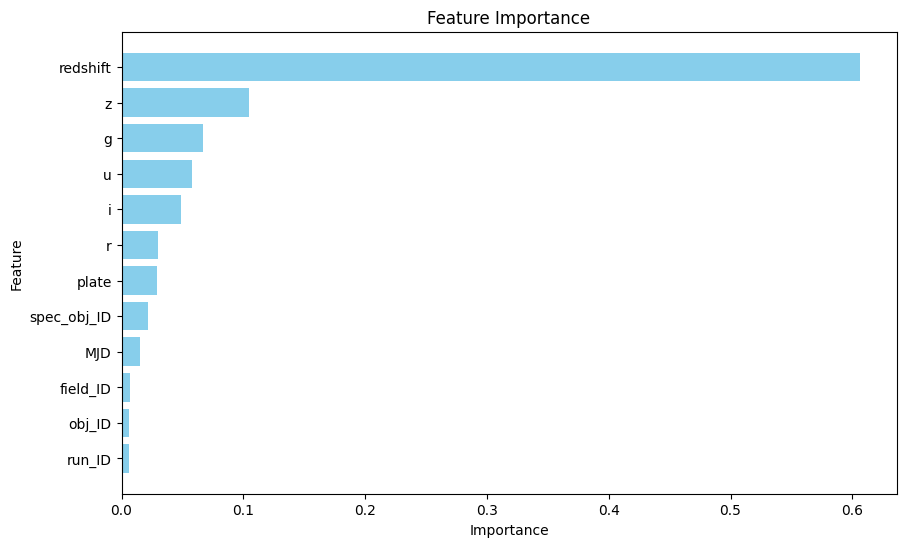

In [ ]:
import matplotlib.pyplot as plt

pandas_feature_importance_df = feature_importance_df.orderBy(feature_importance_df.Importance.desc()).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(pandas_feature_importance_df['Feature'], pandas_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Logistic multinomial regression



In [ ]:
train_data = train_data.withColumnRenamed("class", "label")
test_data = test_data.withColumnRenamed("class", "label")


In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label",
                        maxIter=10, regParam=0.2, elasticNetParam=0.8, family="multinomial")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.2, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [5, 10, 20]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_data)
best_model = cvModel.bestModel

In [ ]:
print("regParam:", best_model.getOrDefault("regParam"))
print("elasticNetParam:", best_model.getOrDefault("elasticNetParam"))
print("iter:", best_model.getOrDefault("maxIter"))

regParam: 0.1
elasticNetParam: 1.0
iter: 5


In [ ]:
best_params = {param[0].name: param[1] for param in best_model.extractParamMap().items()}
best_params

{'aggregationDepth': 2,
 'elasticNetParam': 1.0,
 'family': 'multinomial',
 'featuresCol': 'features',
 'fitIntercept': True,
 'labelCol': 'label',
 'maxBlockSizeInMB': 0.0,
 'maxIter': 5,
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'regParam': 0.1,
 'standardization': True,
 'threshold': 0.5,
 'tol': 1e-06}

In [ ]:
test_data = test_data.withColumnRenamed("label", "class")

predictions = best_model.transform(test_data)

acc, prec, rec, f1 = eval_results(predictions)
print("Evaluation results:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")


Evaluation results:
Accuracy:  0.829
Precision: 0.841
Recall:    0.829
F1 Score:  0.835


# One-vs-Rest Classifier with Linear Support Vector Machine

In [59]:
train_data = train_data.withColumnRenamed("class", "label")
test_data = test_data.withColumnRenamed("class", "label")

In [ ]:
from pyspark.ml.classification import OneVsRest, LinearSVC

linear_svc = LinearSVC(labelCol="label", featuresCol="features")

ovr = OneVsRest(classifier=linear_svc, labelCol="label")


param_grid = (ParamGridBuilder()
              .addGrid(linear_svc.regParam, [0.01, 0.1, 1.0])
              .addGrid(linear_svc.maxIter, [100, 200, 300])
              .build())

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

crossval = CrossValidator(estimator=ovr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

ovr_cvModel = crossval.fit(train_data)

best_model = ovr_cvModel.bestModel

predictions = best_model.transform(test_data)

acc, prec, rec, f1 = eval_results(predictions)
print("Evaluation results:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Evaluation results:
Accuracy:  0.893
Precision: 0.896
Recall:    0.893
F1 Score:  0.895


In [85]:
classifiers = best_model.getClassifier()
param_map = classifiers.extractParamMap()
maxIter = param_map.get(linear_svc.maxIter)
regParam = param_map.get(linear_svc.regParam)
print(f"  maxIter: {maxIter}")
print(f"  regParam: {regParam}")

  maxIter: 100
  regParam: 0.1


In [ ]:
spark.stop()